In [31]:
import numpy as np
from matplotlib import pyplot as plt
import uproot

In [32]:
"""
`with <expression> as <var>` has __enter__ and __exit__ methods
(!) remember to close your file; otherwise, the resources will be too consuming
"""
with uproot.open("QE_MC20_v4_r13167_HWWlvlv.root") as f:
    
    print(f.classnames()) # {"truth;1": "TTree"}
    # ;1 is a cycle number (it"s a convention like first version in ROOT) don"t care about it :)
    
    branches = f["truth;1"]              # select the tree and store its branches
    print(branches)                      # <TTree "truth" (31 branches) at MEMORY_ADDRESS>
    print(branches["higgs_pt"])          # Load the "pt" leaf from the "higgs" branch
    data = branches.arrays(library="np") # Load all branches as numpy arrays

{'truth;1': 'TTree'}
<TTree 'truth' (31 branches) at 0x00013faf62f0>
<TBranch 'higgs_pt' at 0x00013f673b80>


In [33]:
lep_pos_pt = branches["lep_pos_pt"].array()
lep_pos_eta = branches["lep_pos_eta"].array()
lep_pos_phi = branches["lep_pos_phi"].array()
lep_pos_m = np.zeros_like(lep_pos_pt)  # assuming massless leptons for simplicity
nu_pt = branches["nu_pt"].array()
nu_eta = branches["nu_eta"].array()
nu_phi = branches["nu_phi"].array()
nu_m = np.zeros_like(nu_pt)  # assuming massless neutrinos for simplicity

lep_neg_pt = branches["lep_neg_pt"].array()
lep_neg_eta = branches["lep_neg_eta"].array()
lep_neg_phi = branches["lep_neg_phi"].array()
lep_neg_m = np.zeros_like(lep_neg_pt)  # assuming massless leptons
anti_nu_pt = branches["anti_nu_pt"].array()
anti_nu_eta = branches["anti_nu_eta"].array()
anti_nu_phi = branches["anti_nu_phi"].array()
anti_nu_m = np.zeros_like(anti_nu_pt)  # assuming massless neutrinos

In [34]:
def px(pt, phi):
    return pt * np.cos(phi)

def py(pt, phi):
    return pt * np.sin(phi)

def pz(pt, eta):
    return pt * np.sinh(eta)

def energy(pt, eta, m):
    return np.sqrt(np.square(pt) + np.square(pz(pt, eta)) + np.square(m))

############################################################################

def pt(px, py):
    return np.sqrt(np.square(px) + np.square(py))

def eta(px, py, pz):
    pt = np.sqrt(np.square(px) + np.square(py))
    return np.arcsinh(np.divide(pz, pt))

def phi(px, py):
    return np.arctan2(py, px)

def m(e, px, py, pz):
    return np.sqrt(np.maximum(0, np.square(e) - np.square(px) - np.square(py) - np.square(pz)))

In [35]:
lep_pos_px = px(lep_pos_pt, lep_pos_phi)
lep_pos_py = py(lep_pos_pt, lep_pos_phi)
lep_pos_pz = pz(lep_pos_pt, lep_pos_eta)
lep_pos_E = energy(lep_pos_pt, lep_pos_eta, lep_pos_m)
nu_px = px(nu_pt, nu_phi)
nu_py = py(nu_pt, nu_phi)
nu_pz = pz(nu_pt, nu_eta)
nu_E = energy(nu_pt, nu_eta, nu_m)

lep_neg_px = px(lep_neg_pt, lep_neg_phi)
lep_neg_py = py(lep_neg_pt, lep_neg_phi)
lep_neg_pz = pz(lep_neg_pt, lep_neg_eta)
lep_neg_E = energy(lep_neg_pt, lep_neg_eta, lep_neg_m)
anti_nu_px = px(anti_nu_pt, anti_nu_phi)
anti_nu_py = py(anti_nu_pt, anti_nu_phi)
anti_nu_pz = pz(anti_nu_pt, anti_nu_eta)
anti_nu_E = energy(anti_nu_pt, anti_nu_eta, anti_nu_m)

In [36]:
lep_pos_pdgid = branches["lep_pos_pdgId"].array() # retrieve pdgid (refer to the slide)
print(np.unique(lep_pos_pdgid)) # find the unique pdgid in the array
pos_el = (lep_pos_pdgid == -11)
pos_mu = (lep_pos_pdgid == -13)
lep_neg_pdgid = branches["lep_neg_pdgId"].array()
print(np.unique(lep_neg_pdgid))
neg_el = (lep_neg_pdgid == 11)
neg_mu = (lep_neg_pdgid == 13)

[-15, -13, -11]
[11, 13, 15]


In [37]:
# DF -> el and mu with opposite charge
df_mask = (lep_pos_pdgid * lep_neg_pdgid) == (-11 * 13)
assert len(lep_pos_eta[df_mask]) == len(lep_neg_eta[df_mask]), "Shapes are not equal!"
print(f"DF mask sum: {np.sum(df_mask)}")

# work on DF-subset 
# (!) need to index with df_mask first to ensure shapes are consistent physically
lep_pos_pdgid = lep_pos_pdgid[df_mask]
lep_neg_pdgid = lep_neg_pdgid[df_mask]
lep_pos_eta = lep_pos_eta[df_mask]
lep_neg_eta = lep_neg_eta[df_mask]

# TODO: homework
GEV = 1e3

# leps and met
lep_pos_pt = lep_pos_pt[df_mask] / GEV
lep_neg_pt = lep_neg_pt[df_mask] / GEV
lep_pos_px = lep_pos_px[df_mask] / GEV
lep_pos_py = lep_pos_py[df_mask] / GEV
lep_pos_pz = lep_pos_pz[df_mask] / GEV
lep_pos_E = lep_pos_E[df_mask] / GEV
lep_neg_px = lep_neg_px[df_mask] / GEV
lep_neg_py = lep_neg_py[df_mask] / GEV
lep_neg_pz = lep_neg_pz[df_mask] / GEV
lep_neg_E = lep_neg_E[df_mask] / GEV
nu_px = nu_px[df_mask] / GEV
nu_py = nu_py[df_mask] / GEV
anti_nu_px = anti_nu_px[df_mask] / GEV
anti_nu_py = anti_nu_py[df_mask] / GEV
met = pt(nu_px + anti_nu_px, nu_py + anti_nu_py)

# target W bosons
w_pos_pt = branches["w_pos_pt"].array()[df_mask] / GEV
w_pos_eta = branches["w_pos_eta"].array()[df_mask]
w_pos_phi = branches["w_pos_phi"].array()[df_mask]
w_pos_m = branches["w_pos_m"].array()[df_mask] / GEV
w_neg_pt = branches["w_neg_pt"].array()[df_mask] / GEV
w_neg_eta = branches["w_neg_eta"].array()[df_mask]
w_neg_phi = branches["w_neg_phi"].array()[df_mask]
w_neg_m = branches["w_neg_m"].array()[df_mask] / GEV
# convert to (px, py, pz, E)
w_pos_px = px(w_pos_pt, w_pos_phi)
w_pos_py = py(w_pos_pt, w_pos_phi)
w_pos_pz = pz(w_pos_pt, w_pos_eta)
w_pos_E = energy(w_pos_pt, w_pos_eta, w_pos_m)
w_neg_px = px(w_neg_pt, w_neg_phi)
w_neg_py = py(w_neg_pt, w_neg_phi)
w_neg_pz = pz(w_neg_pt, w_neg_eta)
w_neg_E = energy(w_neg_pt, w_neg_eta, w_neg_m)

DF mask sum: 809139


el_mask masks out: 152227
mu_mask masks out: 106859
It's binary, so check unique values: [0, 1]


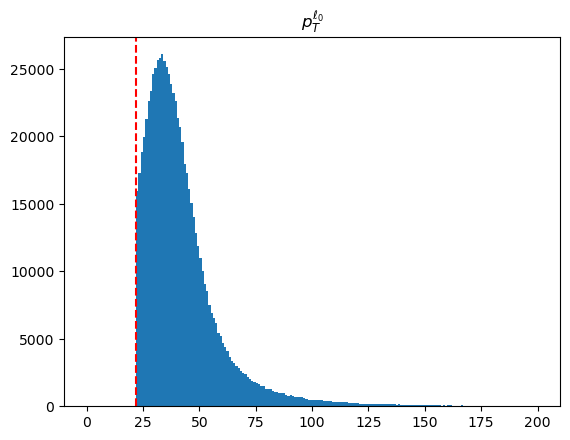

lead_mask masks out: 71265
It's binary, so check unique values: [0, 1]


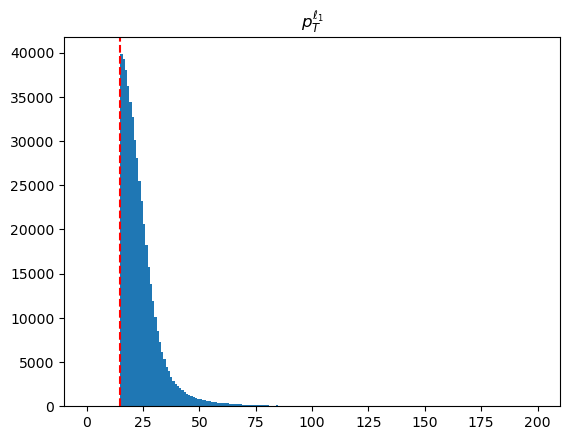

sublead_mask masks out: 320534


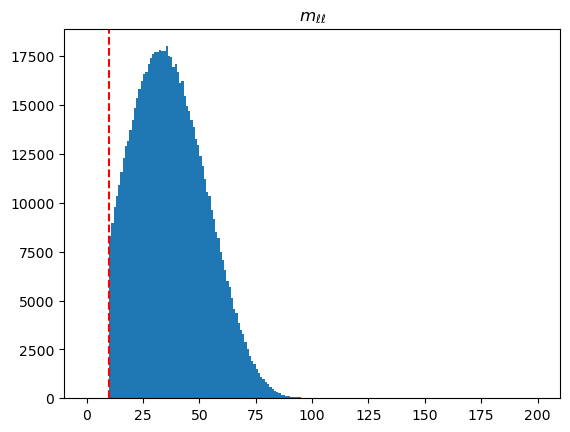

dilep_mass_mask masks out: 40553


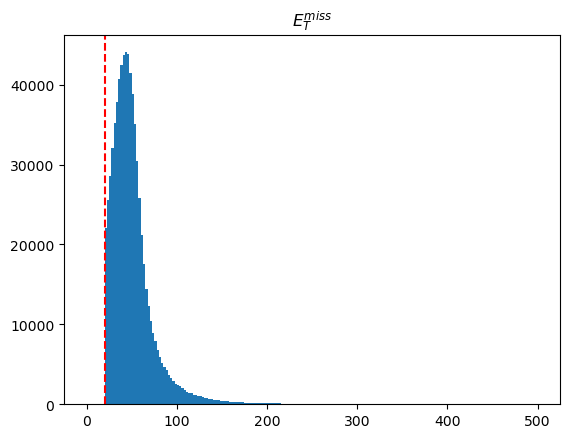

met_mask masks out: 78800
tot_mask masks out: 497195
Surviving events rate: 38.55%


In [38]:
# el selection: abs(eta) < 2.47 and veto crack [1.37, 1.52]
pos_is_e = lep_pos_pdgid == -11
neg_is_e = lep_neg_pdgid == 11
pos_e_accept = (np.abs(lep_pos_eta) < 2.47) & ~((np.abs(lep_pos_eta) > 1.37) & (np.abs(lep_pos_eta) < 1.52))
neg_e_accept = (np.abs(lep_neg_eta) < 2.47) & ~((np.abs(lep_neg_eta) > 1.37) & (np.abs(lep_neg_eta) < 1.52))
el_eta_mask = (pos_is_e & pos_e_accept) | (neg_is_e & neg_e_accept)
print(f"el_mask masks out: {np.sum(df_mask) - np.sum(el_eta_mask)}")

# muon selection: abs(eta) < 2.5
pos_is_mu = lep_pos_pdgid == -13
neg_is_mu = lep_neg_pdgid == 13
pos_mu_accept = (np.abs(lep_pos_eta) < 2.5)
neg_mu_accept = (np.abs(lep_neg_eta) < 2.5)
mu_eta_mask = (pos_is_mu & pos_mu_accept) | (neg_is_mu & neg_mu_accept)
print(f"mu_mask masks out: {np.sum(df_mask) - np.sum(mu_eta_mask)}")

# TODO: rest preselections

# lead lep pt > 22 GeV
pos_is_lead = lep_pos_pt > lep_neg_pt
neg_is_lead = lep_neg_pt > lep_pos_pt
pos_lead_lep_accept = pos_is_lead & (lep_pos_pt > 22)
neg_lead_lep_accept = neg_is_lead & (lep_neg_pt > 22)
lead_lep_mask = pos_lead_lep_accept | neg_lead_lep_accept
print("It's binary, so check unique values:", np.unique(pos_lead_lep_accept*1 + neg_lead_lep_accept*1))
assert np.max(np.unique(pos_lead_lep_accept*1 + neg_lead_lep_accept*1)) <= 1, "Leading lep -> Logic error!"
# do the sanity check (optional)
lead_lep_pt = np.select([pos_is_lead, neg_is_lead], [lep_pos_pt, lep_neg_pt])
plt.hist(lead_lep_pt[lead_lep_mask], bins=200, range=(0, 200))
plt.ylim(0, plt.ylim()[1])
plt.vlines(22, 0, plt.ylim()[1], colors="red", linestyles="dashed")
plt.title(r"$p_T^{\ell_0}$")
plt.show()
print(f"lead_mask masks out: {np.sum(df_mask) - np.sum(lead_lep_mask)}")


# sublead lep pt > 15 GeV
pos_sublead_lep_accept = ~pos_is_lead & (lep_pos_pt > 15)
neg_sublead_lep_accept = ~neg_is_lead & (lep_neg_pt > 15)
sublead_lep_mask = pos_sublead_lep_accept | neg_sublead_lep_accept
print("It's binary, so check unique values:", np.unique(pos_sublead_lep_accept*1 + neg_sublead_lep_accept*1))
assert np.max(np.unique(pos_sublead_lep_accept*1 + neg_sublead_lep_accept*1)) <= 1, "Subleading lep -> Logic error!"
# do the sanity check (optional)
sublead_lep_pt = np.select([~pos_is_lead, ~neg_is_lead], [lep_pos_pt, lep_neg_pt])
plt.hist(sublead_lep_pt[sublead_lep_mask], bins=200, range=(0, 200))
plt.ylim(0, plt.ylim()[1])
plt.vlines(15, 0, plt.ylim()[1], colors="red", linestyles="dashed")
plt.title(r"$p_T^{\ell_1}$")
plt.show()
print(f"sublead_mask masks out: {np.sum(df_mask) - np.sum(sublead_lep_mask)}")

# dilep mass > 10 GeV
dilep_px = lep_pos_px + lep_neg_px
dilep_py = lep_pos_py + lep_neg_py
dilep_pz = lep_pos_pz + lep_neg_pz
dilep_E = lep_pos_E + lep_neg_E
dilep_m = m(dilep_E, dilep_px, dilep_py, dilep_pz)
dilep_mass_mask = dilep_m > 10
# do the sanity check (optional)
plt.hist(dilep_m[dilep_mass_mask], bins=200, range=(0, 200))
plt.ylim(0, plt.ylim()[1])
plt.vlines(10, 0, plt.ylim()[1], colors="red", linestyles="dashed")
plt.title(r"$m_{\ell\ell}$")
plt.show()
print(f"dilep_mass_mask masks out: {np.sum(df_mask) - np.sum(dilep_mass_mask)}")

# met  > 20 GeV
met_mask = met > 20
# do the sanity check (optional)
plt.hist(met[met_mask], bins=200, range=(0, 500))
plt.ylim(0, plt.ylim()[1])
plt.vlines(20, 0, plt.ylim()[1], colors="red", linestyles="dashed")
plt.title(r"$E_T^{miss}$")
plt.show()
print(f"met_mask masks out: {np.sum(df_mask) - np.sum(met_mask)}")

# total mask
tot_mask = el_eta_mask & mu_eta_mask & lead_lep_mask & sublead_lep_mask & dilep_mass_mask & met_mask
assert np.sum(df_mask) == len(tot_mask), "Shapes are not equal!"
print("="*30)
print(f"tot_mask masks out: {np.sum(df_mask) - np.sum(tot_mask)}")
print(f"Surviving events rate: {100 * np.sum(tot_mask) / len(tot_mask):.2f}%")

In [39]:
# W bosons associated with leading and subleading leptons
w0_mass = np.select([pos_is_lead, neg_is_lead], [w_pos_m, w_neg_m])
w1_mass = np.select([~pos_is_lead, ~neg_is_lead], [w_pos_m, w_neg_m])

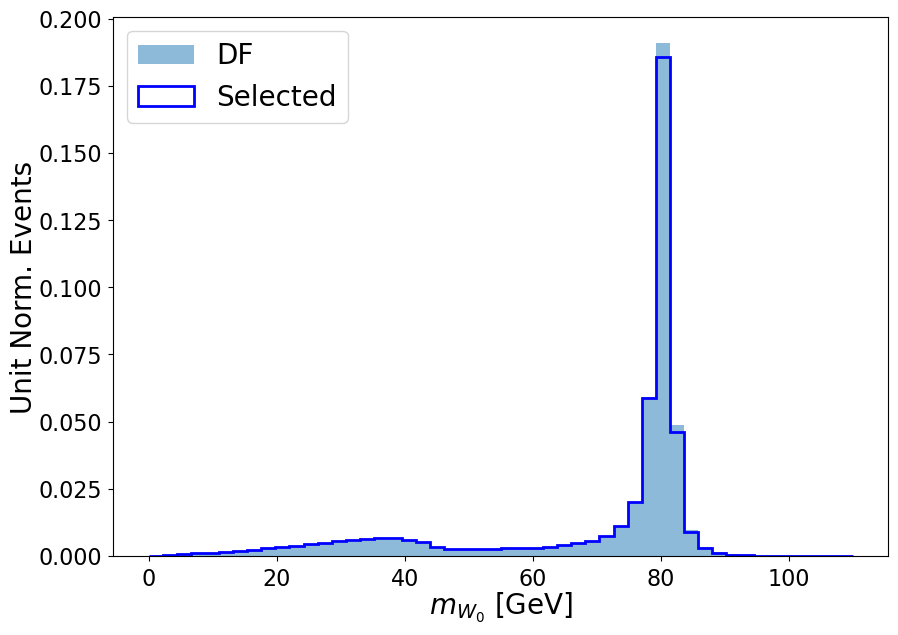

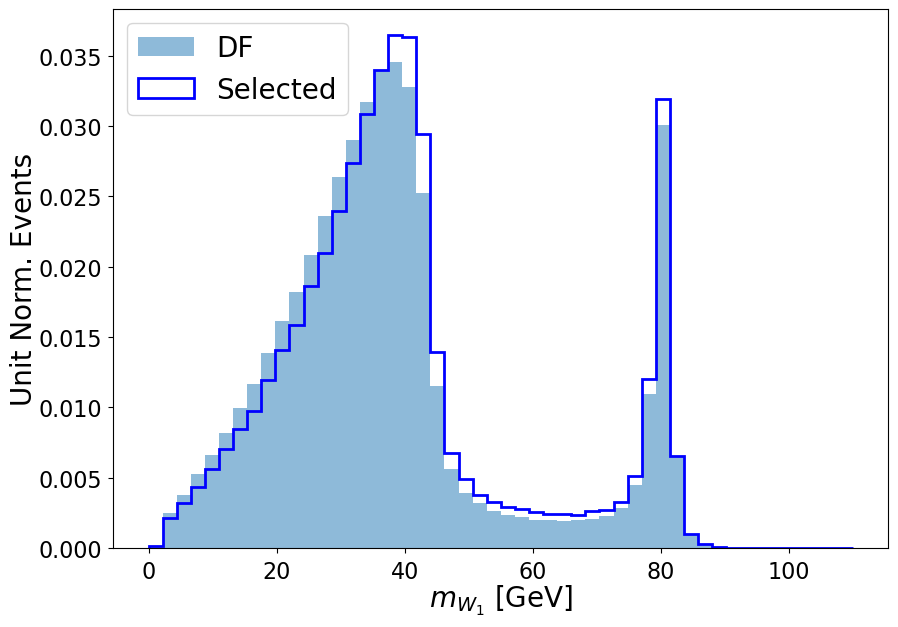

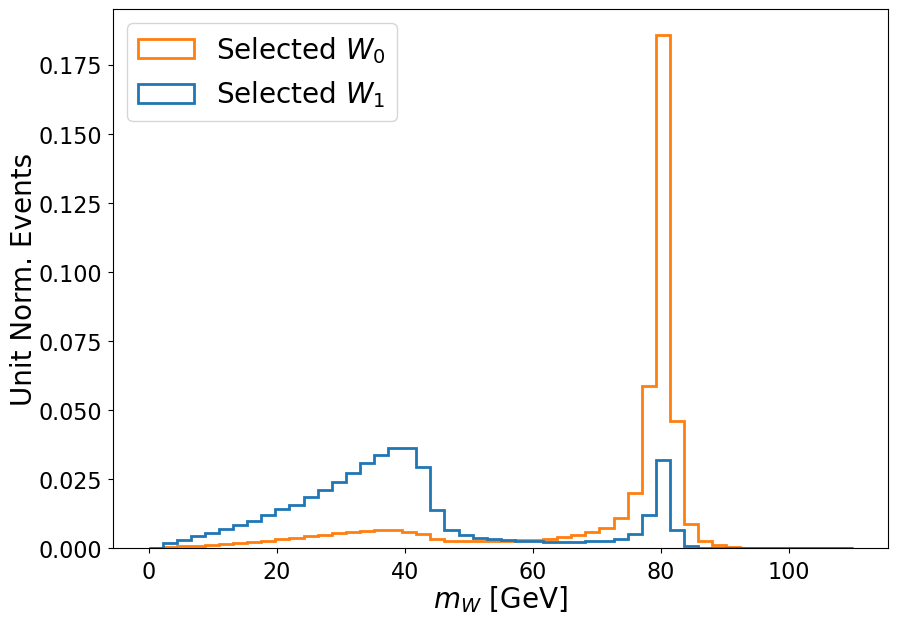

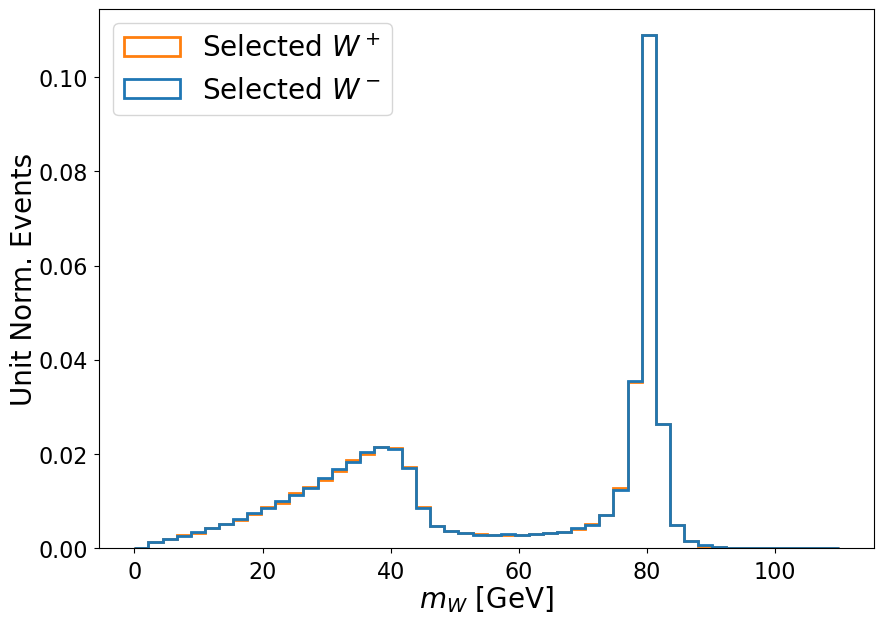

In [41]:
# plot w0 mass
fig = plt.figure(figsize=(10, 7))
bins_edges = np.linspace(0, 110, 51) # important to fix bins_edges
plt.hist(w0_mass, bins=bins_edges, histtype="bar", alpha=0.5, color="tab:blue", label=r"DF", density=True)
plt.hist(w0_mass[tot_mask], bins=bins_edges, histtype="step", linewidth=2, color="blue", label=r"Selected", density=True)
plt.legend(loc="best", fontsize=20)
plt.xlabel("$m_{W_0}$ [GeV]", fontsize=20, labelpad=0) # remember to include unit (in the proper order)
plt.ylabel("Unit Norm. Events", fontsize=20, labelpad=0) 
plt.tick_params(axis="both", which="major", labelsize=16, pad=5)
# plt.yscale("log")
# plt.savefig("lepton_pt.pdf", bbox_inches="tight") # save in vector format (e.g., pdf), trim out extra white space
plt.show()

# plot w1 mass
fig = plt.figure(figsize=(10, 7))
plt.hist(w1_mass, bins=bins_edges, histtype="bar", alpha=0.5, color="tab:blue", label=r"DF", density=True)
plt.hist(w1_mass[tot_mask], bins=bins_edges, histtype="step", linewidth=2, color="blue", label=r"Selected", density=True)
plt.legend(loc="best", fontsize=20)
plt.xlabel("$m_{W_1}$ [GeV]", fontsize=20, labelpad=0)
plt.ylabel("Unit Norm. Events", fontsize=20, labelpad=0) 
plt.tick_params(axis="both", which="major", labelsize=16, pad=5)
plt.show()

# plot together
fig = plt.figure(figsize=(10, 7))
plt.hist(w0_mass[tot_mask], bins=bins_edges, histtype="step", linewidth=2, color="tab:orange", label=r"Selected $W_0$", density=True)
plt.hist(w1_mass[tot_mask], bins=bins_edges, histtype="step", linewidth=2, color="tab:blue", label=r"Selected $W_1$", density=True)
plt.legend(loc="best", fontsize=20)
plt.xlabel("$m_{W}$ [GeV]", fontsize=20, labelpad=0)
plt.ylabel("Unit Norm. Events", fontsize=20, labelpad=0) 
plt.tick_params(axis="both", which="major", labelsize=16, pad=5)
plt.show()
fig = plt.figure(figsize=(10, 7))
plt.hist(w_pos_m[tot_mask], bins=bins_edges, histtype="step", linewidth=2, color="tab:orange", label=r"Selected $W^+$", density=True)
plt.hist(w_neg_m[tot_mask], bins=bins_edges, histtype="step", linewidth=2, color="tab:blue", label=r"Selected $W^-$", density=True)
plt.legend(loc="best", fontsize=20)
plt.xlabel("$m_{W}$ [GeV]", fontsize=20, labelpad=0)
plt.ylabel("Unit Norm. Events", fontsize=20, labelpad=0) 
plt.tick_params(axis="both", which="major", labelsize=16, pad=5)
plt.show()
